# Example With Tenserflow - DNN

# imports

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Create Tensorflow Dataset

In [16]:
LABEL_COLUMN = 'Pos'
file_pattern = '../data/preprocessed/refine4.csv'
batch_size = 15
SELECT_COLUMNS = ['LightPer','RSSI1', 'RSSI2', 'RSSI3', 'Lux', 'Acc_x', 'Acc_y','Acc_z','Temp','ID','Pos']
number_feature_col = 10
all_dataset = tf.data.experimental.make_csv_dataset(
    file_pattern,
    1,
    label_name=LABEL_COLUMN,
    select_columns = SELECT_COLUMNS,
    na_value='?',
    header=True,
    num_epochs=1,
    shuffle=True,
    ignore_errors=True
)

## Make Test And Traing

In [17]:
test_dataset = all_dataset.take(10000) 
test_dataset = test_dataset.batch(batch_size)
features, labels = next(iter(test_dataset))
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels


test_dataset = test_dataset.map(pack_features_vector)
features, labels = next(iter(test_dataset))

train_dataset = all_dataset.skip(10000)
train_dataset = train_dataset.batch(batch_size)
features, labels = next(iter(train_dataset))



train_dataset = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_dataset))

features = tf.cast( features, tf.float32,  name='Cast feature')
features = tf.reshape(features ,[-1, number_feature_col] )
labels = tf.reshape(labels ,[-1] )

# Create Model

In [20]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(100, activation=tf.nn.relu, input_shape=(number_feature_col,)), 
  tf.keras.layers.Dense(200, activation=tf.nn.relu),
  tf.keras.layers.Dense(300)
])
predictions = model(features)
predictions[:number_feature_col]
tf.nn.softmax(predictions[:number_feature_col])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_7 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_8 (Dense)              (None, 300)               60300     
Total params: 81,600
Trainable params: 81,600
Non-trainable params: 0
_________________________________________________________________


## Loss Function 

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y, training):
  y_ = model(x, training=training)
  return loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Train Model

In [22]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 21

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of dataset
    for x, y in train_dataset:
        x = tf.cast( x, tf.float32,  name='x feature')
        x = tf.reshape(x ,[-1, number_feature_col] )
        y = tf.reshape(y ,[-1] )
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss_avg(loss_value) 
        epoch_accuracy(y, model(x, training=True))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 5 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, epoch_loss_avg.result(), epoch_accuracy.result()))
                                                                

Epoch 000: Loss: 2.626, Accuracy: 46.543%
Epoch 005: Loss: 0.243, Accuracy: 96.804%
Epoch 010: Loss: 0.145, Accuracy: 98.498%
Epoch 015: Loss: 0.118, Accuracy: 98.914%
Epoch 020: Loss: 0.104, Accuracy: 99.130%


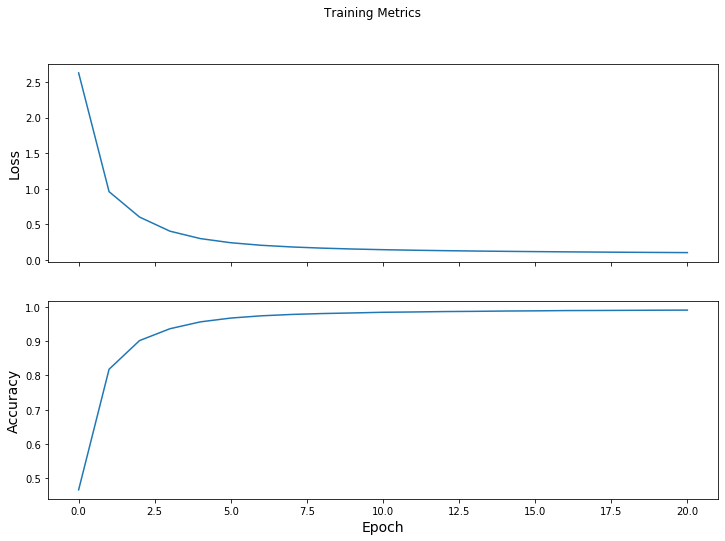

In [23]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

# Test Result

In [24]:
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
for x, y in test_dataset:
    x = tf.cast( x, tf.float32,  name='x feature')
    x = tf.reshape(x ,[-1, number_feature_col] )
    y = tf.reshape(y ,[-1] )
    loss_value, grads = grad(model, x, y)
    epoch_loss_avg(loss_value)  # Add current batch loss
    epoch_accuracy(y, model(x, training=False))
print("Test Result: Loss: {:.3f}, Accuracy: {:.3%}".format( epoch_loss_avg.result(), epoch_accuracy.result()))    

Test Result: Loss: 0.242, Accuracy: 89.890%
